In [ ]:
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from typing import Callable
import random

%matplotlib inline

In [3]:
def f(x: float | np.ndarray):
    return 3 * x**2 - 4 * x + 5

In [4]:
f(3.0)

20.0

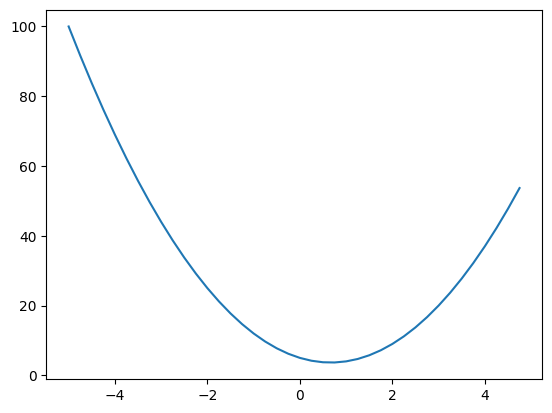

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
f(2 / 3)

3.666666666666667

In [15]:
# x = 2 / 3
# h = 0.00001
# (f(x + h) - f(x)) / h
x = 3.0
h = 0.000000000000000001
(f(x + h) - f(x)) / h

0.0

In [16]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

In [23]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
# modify
c += h
d2 = a * b + c

print(f"{d1=}")
print(f"{d2=}")
print(f"slope={(d2 - d1) / h}")

d1=4.0
d2=4.0001
slope=0.9999999999976694


neural networks are massive, so we need some sort of data structure to help us build these neural networks


In [30]:
class Value:
    def __init__(
        self,
        data: float,
        *,
        label="",
        prev: tuple["Value", ...] = tuple(),
        op: str | None = None,
    ) -> None:
        self.data: float = data
        self.label: str = label
        self.grad: float = 0.0
        self._prev = set(prev)
        self._grad_fn: Callable[[], None] | None = None
        self._op = op

    def __repr__(self) -> str:
        repr = [
            f"label='{self.label}'" if self.label != "" else None,
            f"data={self.data:0.4f}",
            f"grad={self.grad:0.4f}" if self.grad != 0 else None,
            f"grad_fn=<{self._grad_fn.__name__}>" if self._grad_fn else None,
        ]
        repr = ", ".join(filter(None, repr))
        return f"Value({repr})"

    __str__ = __repr__

    def __add__(self, other: "Value | float | int") -> "Value":
        other = Value(float(other)) if isinstance(other, (float, int)) else other
        out = Value(self.data + other.data, prev=(self, other), op="+")

        def AddBackward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._grad_fn = AddBackward
        return out

    def __mul__(self, other: "Value | float | int") -> "Value":
        other = Value(float(other)) if isinstance(other, (float, int)) else other
        out = Value(self.data * other.data, prev=(self, other), op="×")

        def MulBackward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._grad_fn = MulBackward
        return out

    def __neg__(self) -> "Value":
        return self * -1

    def __sub__(self, other: "Value | int | float") -> "Value":
        return self + (-other)

    def __truediv__(self, other: "Value | int | float") -> "Value":
        return self * other**-1

    def __pow__(self, other: int | float) -> "Value":
        assert isinstance(other, (int, float)), (
            "only floating point or integer powers are implemented"
        )
        out = Value(self.data**other, op="pow", prev=(self,), label=f"^{other}")

        def PowBackward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._grad_fn = PowBackward
        return out

    def __rmul__(self, other: float | int) -> "Value":
        return self * other

    def __radd__(self, other: float | int) -> "Value":
        return self + other

    def tanh(self) -> "Value":
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, prev=(self,), op="tanh")

        def TanhBackward():
            self.grad += out.grad * (1 - t**2)

        out._grad_fn = TanhBackward
        return out

    def relu(self, *, leaky: bool = False) -> "Value":
        x1, x2 = self.data, (0.01 * self.data if leaky else 0.0)
        out = Value(max(x1, x2), prev=(self,), op="relu")

        def ReLUBackward():
            local_grad = 0.01 if leaky else 0.0
            self.grad += out.grad * (1.0 if self.data > 0 else local_grad)

        self._grad_fn = ReLUBackward
        return out

    def exp(self) -> "Value":
        out = Value(math.exp(self.data), op="exp", prev=(self,))

        def ExpBackward():
            self.grad += out.grad * out.data

        self._grad_fn = ExpBackward
        return out

    def backward(self):
        def build_topo(
            v: Value,
            topo: list | None = None,
            visited: set | None = None,
        ) -> list[Value]:
            topo = topo if topo is not None else []
            visited = visited if visited is not None else set()
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child, topo, visited)
                topo.append(v)
            return topo

        self.grad = 1.0
        topo = build_topo(self)
        for node in reversed(topo):
            if node._grad_fn is not None:
                node._grad_fn()


In [31]:
def trace(root: Value) -> tuple[set[Value], set[tuple[Value, Value]]]:
    nodes, edges = set(), set()

    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

In [44]:
def draw_dot(root: Value):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        disp = f"{{ {n.label} | {n.data:.4f} | grad {n.grad:.4f} }}"
        print(disp)
        dot.node(uid, disp, shape="record")
        if n._op is not None:
            dot.node(uid + n._op, n._op)  # create op node if it exists
            dot.edge(uid + n._op, uid)  # connect op node with the value node

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + getattr(n2, "_op", ""))
    return dot


{  | 10.0000 | grad 0.0000 }
{  | 4.0000 | grad 0.0000 }
{  | 2.0000 | grad 0.0000 }
{  | -3.0000 | grad 0.0000 }
{  | -6.0000 | grad 0.0000 }


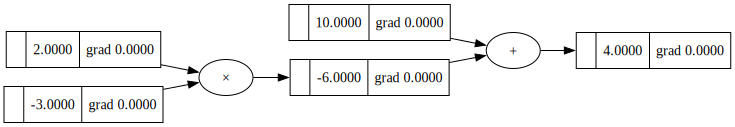

In [45]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a * b + c
draw_dot(d)

In [34]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a * b
e.label = "e"

d = e + c
# dd/de =
d.label = "d"

f = Value(-2.0, label="f")

L = d * f
L.label = "L"

L


# a * b + c
# dd/dc= ?

Value(label='L', data=-8.0000, grad_fn=<MulBackward>)

$$
\begin{align}
\frac{dd}{dc} =\ ? \\
d = e + c
\end{align}
$$

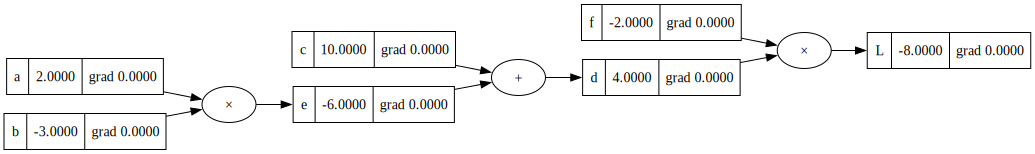

In [35]:
draw_dot(L)

$$
\begin{align}
\frac{\partial L}{\partial d} &=\ ? \\
\frac{\partial L}{\partial f} &=\ ? \\
L &= d \cdot f \\
\frac{\partial L}{\partial d} &= f \\
\frac{\partial L}{\partial f} &= d
\end{align}
$$

$$
\begin{align}
\frac{\partial d}{\partial c} &=\ ? \\
\frac{\partial d}{\partial e} &=\ ? \\
d &= e + c \\
\frac{\partial d}{\partial c} &= 1.0 \\
\frac{\partial d}{\partial e} &= 1.0
\end{align}
$$

$$
\begin{align}
\frac{\partial e}{\partial a} &=\ ? \\
\frac{\partial e}{\partial b} &=\ ? \\
e &= a \cdot b \\
\frac{\partial e}{\partial a} &= b \\
\frac{\partial e}{\partial b} &= a
\end{align}
$$

$$
\begin{align}
\frac{\partial L}{\partial c} &=\ ? \\
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} \\
&= f \cdot 1.0 \\
&= f
\end{align}
$$

$$
\begin{align}
\frac{\partial L}{\partial a} &=\ ? \\
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} \cdot \frac{\partial e}{\partial a} \\
&= f \cdot 1.0 \cdot b \\
&= f \cdot b
\end{align}
$$

$$
\begin{align}
\frac{\partial L}{\partial b} &=\ ? \\
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} \cdot \frac{\partial e}{\partial b} \\
&= f \cdot 1.0 \cdot a \\
&= f \cdot a
\end{align}
$$

In [11]:
L.grad = 1.0

d.grad = f.data  # -2.0
f.grad = d.data  # 4.0

c.grad = d.grad * 1.0  # gradient that flows in * local gradient
e.grad = d.grad * 1.0  # through symmetry

a.grad = (
    f.data * 1.0 * b.data
)  # gradient flows from (dL/dd -> dL/dc) global gradient * de/da (local gradient)
b.grad = f.data * 1.0 * a.data  # through symmetry

In [ ]:
def lol():
    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    f += h  # mod
    L = d * f
    L.label = "L"
    L2 = L.data
    print((L2 - L1) / h)


lol()

3.9999999999995595


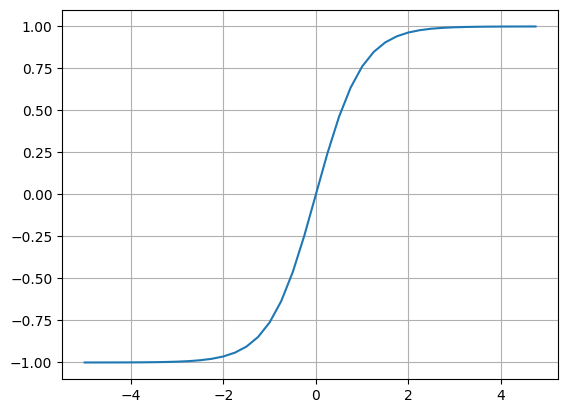

In [13]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(np.arange(-5, 5, 0.25))
plt.grid()
plt.plot(xs, ys)

In [14]:
x1, x2 = Value(2.0, label="x1"), Value(0.0, label="x2")
w1, w2 = Value(-3.0, label="w1"), Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

do/dn = 1 - o^2 # since o is already tanh(x)

do/dx1 = do/do * do/dn * do/dx1w1x2w2  * 

In [15]:
o.grad = 1.0
n.grad = 1 - o.data**2

b.grad = n.grad
x1w1x2w2.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
assert o._grad_fn is not None
assert n._grad_fn is not None
assert x1w1x2w2._grad_fn is not None
assert x2w2._grad_fn is not None
assert x1w1._grad_fn is not None

o.grad = 1.0
o._grad_fn()
n._grad_fn()
x1w1x2w2._grad_fn()
x2w2._grad_fn()
x1w1._grad_fn()

In [17]:
o.backward()

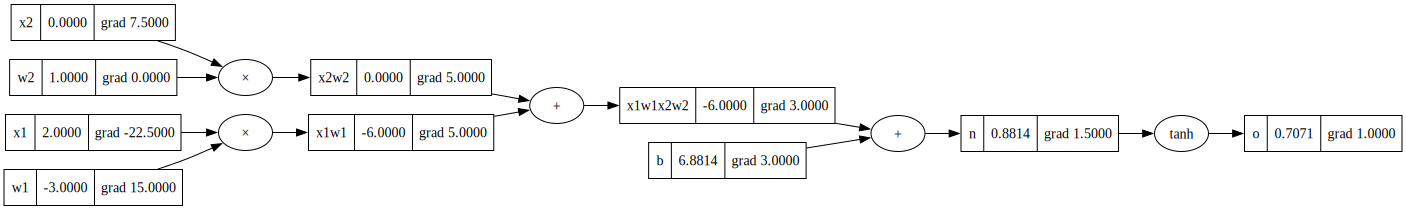

In [18]:
draw_dot(o)

In [ ]:
class Neuron:
    def __init__(self, n_in: int) -> None:
        self.w = [Value(random.uniform(-1, 1) * 0.1) for _ in range(0, n_in)]  # shape: (n_in,)
        self.b = Value(random.uniform(-1, 1) * 0.1)  # shape (1,)

    def __call__(self, x: list[float]) -> Value:
        # |x| = |W|, since each neuron will have as
        # many weights as it receives inputs.
        product = (xi * wi for xi, wi in zip(x, self.w))  # shape: (x,)
        acc = sum(product, self.b)  # shape: (x,) -> (1,)
        return acc.tanh()  # shape (1,)

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, n_in: int, n_out: int) -> None:
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
        print(f"layer has neurons: {len(self.neurons)}")

    def __call__(self, x: list[float]) -> Value | list[Value]:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]


class MLP:
    def __init__(self, n_in: int, n_outs: list[int]) -> None:
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outs))]
        print(f"num layers: {len(self.layers)}")

    def __call__(self, x: list[float]) -> Value | list[Value]:
        for layer in self.layers:
            x = layer(x)  # type: ignore : turns into list of values after layer calls
        return x  # type: ignore

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

In [20]:
# XOR = | T | F | O |
#       |:-:|:-:|:-:|
#       | 0 | 0 | 0 |
#       | 0 | 1 | 1 |
#       | 1 | 0 | 1 |
#       | 1 | 1 | 0 |
xs = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]]
ys = [0.0, 1.0, 1.0, 0.0]
# ys = [0.0, 0.0, 0.0, 1.0]

In [21]:
model = MLP(n_in=2, n_outs=[4, 1])

layer has neurons: 4
layer has neurons: 1
num layers: 2


In [22]:
steps = 3000
log_every = int(steps * 0.1)  # every 10% of the way there
for k in range(1, steps + 1):
    ypred: list[Value | list[Value]] = [model(x) for x in xs]
    # print(*ypred, sep="\n")
    loss: Value = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))  # type: ignore
    model.zero_grad()
    loss.backward()
    # update
    for p in model.parameters():
        p.data += -0.1 * p.grad

    if k % log_every == 0:
        print(k, loss.data)


300 0.9901668227035527
600 0.0146152299873291
900 0.006096336136585274
1200 0.00307894172960437
1500 0.0021521736995033995
1800 0.0016499055743474608
2100 0.0013188359221639936
2400 0.0010932074859151242
2700 0.000931814368000608
3000 0.0008124928454695634


In [23]:
ypred

[Value(data=-0.0048, grad=-0.0096, grad_fn=<TanhBackward>),
 Value(data=0.9860, grad=-0.0281, grad_fn=<TanhBackward>),
 Value(data=0.9862, grad=-0.0277, grad_fn=<TanhBackward>),
 Value(data=-0.0200, grad=-0.0401, grad_fn=<TanhBackward>)]

In [24]:
for x, y in zip(xs, ys):
    inference = model(x)
    inference = inference.data if isinstance(inference, Value) else inference[0].data
    # assert inference - y < 1e-4
    print(f"{inference:.4f} == {y}")


0.0054 == 0.0
0.9870 == 1.0
0.9872 == 1.0
0.0211 == 0.0


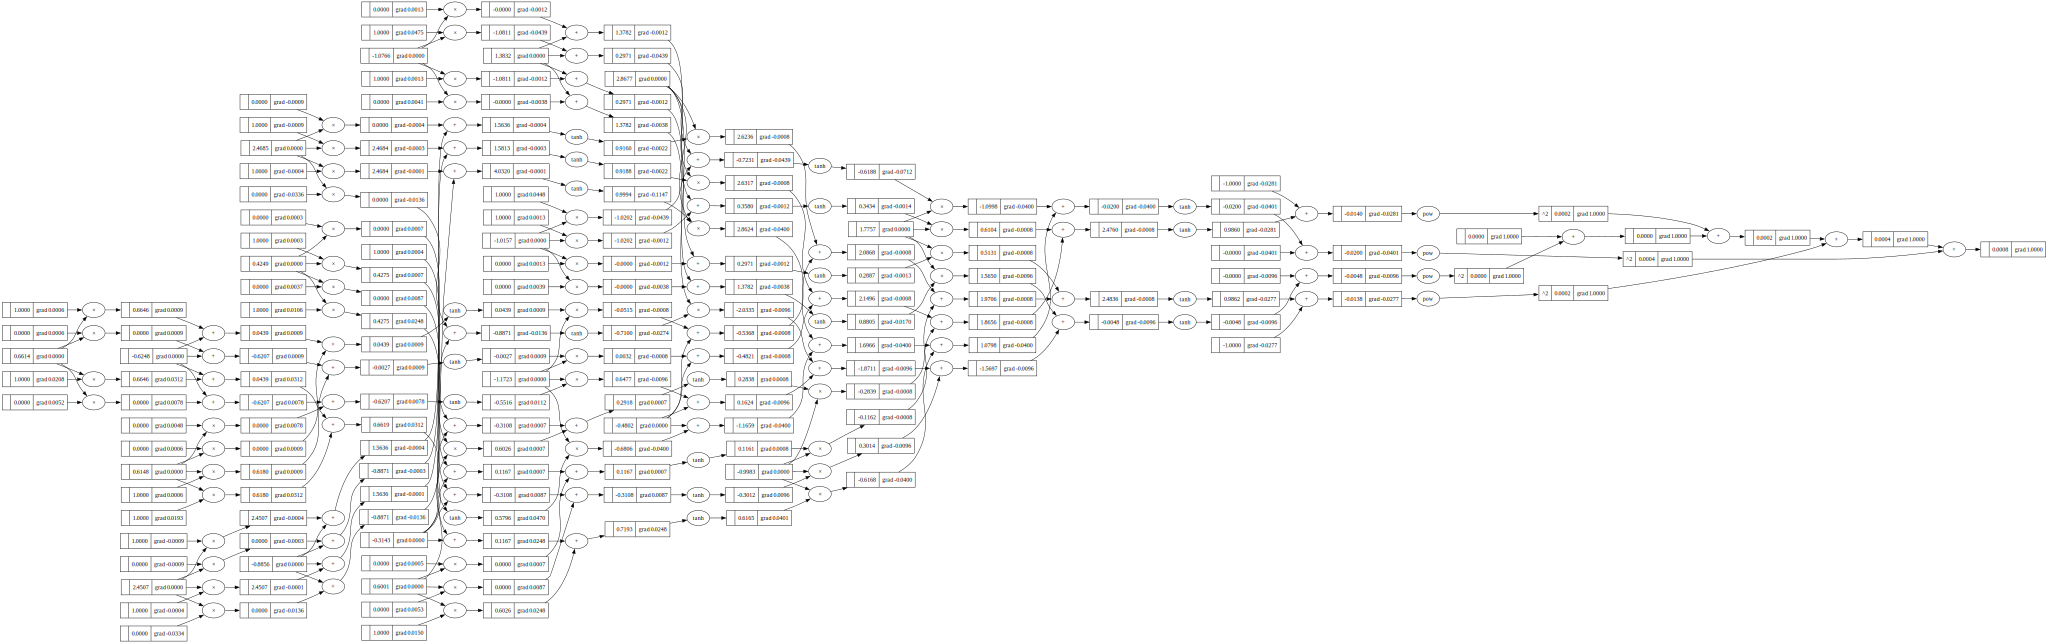

In [25]:
model.zero_grad()
draw_dot(loss)

In [26]:
x, y = Value(2.0, label="x"), Value(-5.0, label="y")
c = x + y
c.label = "c"
z = c * x
z.label = "z"
z.backward()
for v in [x, y, c, z]:
    print(v)

Value(label='x', data=2.0000, grad=-1.0000)
Value(label='y', data=-5.0000, grad=2.0000)
Value(label='c', data=-3.0000, grad=2.0000, grad_fn=<AddBackward>)
Value(label='z', data=-6.0000, grad=1.0000, grad_fn=<MulBackward>)
